In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from itertools import combinations

In [3]:
df = pd.read_csv("/Users/annabruns/Documents/~NYU/Research/Crowding/correlation/github/crowding-individual-difference/data/tidy_corr_data_log.csv")

In [4]:
df.columns

Index(['prolificID', 'acuity_block1', 'acuity_block2', 'acuity_grandMean',
       'crowding_block1', 'crowding_block2', 'crowding_block3',
       'crowding_block4', 'crowding_grandMean', 'rsvp_block1', 'rsvp_block2',
       'rsvp_grandMean', 'reading_block1', 'reading_block2',
       'reading_grandMean'],
      dtype='object')

In [5]:
df.head()

,prolificID,acuity_block1,acuity_block2,acuity_grandMean,crowding_block1,crowding_block2,crowding_block3,crowding_block4,crowding_grandMean,rsvp_block1,rsvp_block2,rsvp_grandMean,reading_block1,reading_block2,reading_grandMean
0,559ad287fdf99b219a612d22,-0.415187,-0.480609,-0.447898,0.845687,0.882659,0.950354,1.040760,0.929865,2.523579,2.742889,2.633234,2.322498,2.234990,2.278744
1,55d51a6b8ce09000127d4821,-0.596659,-0.670809,-0.633734,0.089592,0.041552,0.119450,-0.103568,0.036757,NaN,NaN,NaN,2.398362,2.281513,2.339937
2,5685850c333cbd000d4e042f,-0.494388,-0.540586,-0.517487,NaN,NaN,NaN,NaN,NaN,3.252130,3.274171,3.263151,2.344673,2.411041,2.377857
3,56b78f11e77ebe000cbefe79,-0.463865,-0.440105,-0.451985,NaN,NaN,NaN,NaN,NaN,3.038510,3.251385,3.144948,2.538969,2.422927,2.480948
4,57334d427d01ed00098e8e69,-0.526725,-0.552582,-0.539654,0.365720,0.148872,0.053535,0.335556,0.225920,3.198827,3.096109,3.147468,2.393182,2.268736,2.330959


In [14]:
cols = ['acuity_block1', 'acuity_block2', 'crowding_block1', 'crowding_block2', 
        'rsvp_block1', 'rsvp_block2', 'reading_block1', 'reading_block2']
df_for_boot = df[cols].copy()

In [15]:
df_for_boot.head()

,acuity_block1,acuity_block2,crowding_block1,crowding_block2,rsvp_block1,rsvp_block2,reading_block1,reading_block2
0,-0.415187,-0.480609,0.845687,0.882659,2.523579,2.742889,2.322498,2.234990
1,-0.596659,-0.670809,0.089592,0.041552,NaN,NaN,2.398362,2.281513
2,-0.494388,-0.540586,NaN,NaN,3.252130,3.274171,2.344673,2.411041
3,-0.463865,-0.440105,NaN,NaN,3.038510,3.251385,2.538969,2.422927
4,-0.526725,-0.552582,0.365720,0.148872,3.198827,3.096109,2.393182,2.268736


In [16]:
print("Number of NaN values in each column:")
print(df_for_boot.isnull().sum())

print("\nPercentage of NaN values in each column:")
print((df_for_boot.isnull().sum() / len(df_for_boot) * 100).round(2))

Number of NaN values in each column:
acuity_block1      14
acuity_block2      14
crowding_block1    57
crowding_block2    57
rsvp_block1        21
rsvp_block2        21
reading_block1     64
reading_block2     64
dtype: int64

Percentage of NaN values in each column:
acuity_block1       8.48
acuity_block2       8.48
crowding_block1    34.55
crowding_block2    34.55
rsvp_block1        12.73
rsvp_block2        12.73
reading_block1     38.79
reading_block2     38.79
dtype: float64


In [17]:
def compute_noise_ceiling_splitHalf(measurements):
    """
    Reference: Diedrichsen
    Computes the noise ceiling for a set of repeated measurements.
    Uses split-half reliability across multiple measurements and the geometric mean formula.
    """
    # Convert to numpy array and handle missing values
    measurements = measurements.dropna()
    if len(measurements) < 2:
        return np.nan
    
    n_measurements = measurements.shape[1]
    
    if n_measurements < 2:
        return np.nan
    
    odd_half = measurements.iloc[:, 1::2]
    even_half = measurements.iloc[:, 0::2]
    
    if odd_half.shape[1] == 0 or even_half.shape[1] == 0:
        return np.nan
    
    r_i, _ = pearsonr(np.mean(odd_half, axis=1), np.mean(even_half, axis=1))

    # Apply the extrapolation formula for multiple measurements (2 halves)
    N = 2
    r_m = (N * r_i) / ((r_i * (N - 1)) + 1)

    return r_m

In [18]:
def apply_spear_correction(x_measurements, y_measurements):
    """
    Apply Spearman correction for measurement error
    """
    # Remove rows with any missing values
    valid_mask = ~(x_measurements.isna().any(axis=1) | y_measurements.isna().any(axis=1))
    x_clean = x_measurements[valid_mask]
    y_clean = y_measurements[valid_mask]
    
    if len(x_clean) < 2:
        return np.nan, np.nan
    
    x_mean = np.mean(x_clean, axis=1)
    y_mean = np.mean(y_clean, axis=1)

    r_naive, _ = pearsonr(x_mean, y_mean)

    Rxx = compute_noise_ceiling_splitHalf(x_clean)
    Ryy = compute_noise_ceiling_splitHalf(y_clean)
    
    if np.isnan(Rxx) or np.isnan(Ryy) or Rxx <= 0 or Ryy <= 0:
        return r_naive, np.nan
    
    lam = np.sqrt(Rxx * Ryy)
    r_corrected = r_naive / lam
    
    return r_naive, r_corrected

In [19]:
def bootstrap_correlation(df, task1, task2, n_boot, sample_size, apply_correction=False):
    """
    Run bootstrap analysis for correlation between two tasks
    """
    # Create task names
    task1_block1 = f'{task1}_block1'
    task1_block2 = f'{task1}_block2'
    task2_block1 = f'{task2}_block1'
    task2_block2 = f'{task2}_block2'
    
    # Calculate arithmetic mean of block 1 and 2 (after log transform)
    # Handle missing values by taking log only of non-missing values
    df[f'{task1}_mean'] = np.nan
    df[f'{task2}_mean'] = np.nan
    
    # For task1
    valid_mask1 = ~(df[task1_block1].isna() | df[task1_block2].isna())
    df.loc[valid_mask1, f'{task1}_mean'] = np.mean([
        np.log(df.loc[valid_mask1, task1_block1]), 
        np.log(df.loc[valid_mask1, task1_block2])
    ], axis=0)
    
    # For task2
    valid_mask2 = ~(df[task2_block1].isna() | df[task2_block2].isna())
    df.loc[valid_mask2, f'{task2}_mean'] = np.mean([
        np.log(df.loc[valid_mask2, task2_block1]), 
        np.log(df.loc[valid_mask2, task2_block2])
    ], axis=0)
    
    # Remove rows with missing data
    df_clean = df.dropna(subset=[f'{task1}_mean', f'{task2}_mean'])
    n = len(df_clean)
    
    if n < 2:
        print(f"Warning: Not enough data for {task1} vs {task2}")
        return np.nan, [np.nan, np.nan], np.full(n_boot, np.nan)
    
    boot_corrs = np.zeros(n_boot)
    
    for i in range(n_boot):
        # Sample without replacement
        sample_idx = np.random.choice(n, size=min(sample_size, n), replace=False)
        d = df_clean.iloc[sample_idx]
        
        if len(d) < 2:
            boot_corrs[i] = np.nan
        else:
            if apply_correction:
                # Prepare measurements for Spearman correction
                x_measurements = d[[task1_block1, task1_block2]]
                y_measurements = d[[task2_block1, task2_block2]]
                
                try:
                    r_naive, r_corrected = apply_spear_correction(x_measurements, y_measurements)
                    boot_corrs[i] = r_corrected
                except:
                    boot_corrs[i] = np.nan
            else:
                # Regular correlation
                try:
                    boot_corrs[i] = d[f'{task1}_mean'].corr(d[f'{task2}_mean'], method='pearson')
                except:
                    boot_corrs[i] = np.nan
    
    # Results
    mean_corr = np.nanmean(boot_corrs)
    ci = np.nanpercentile(boot_corrs, [2.5, 97.5])
    
    return mean_corr, ci, boot_corrs

In [21]:
def run_all_analyses(df, n_boot, sample_size):
    """
    Run bootstrap analysis for all pairwise combinations
    """
    tasks = ['crowding', 'acuity', 'rsvp', 'reading']
    task_pairs = list(combinations(tasks, 2))
    
    results = {}
    
    for task1, task2 in task_pairs:
        print(f"\n{'='*50}")
        print(f"Analysis: {task1} vs {task2}")
        print(f"{'='*50}")
        
        # Regular bootstrap
        print("\n1. Regular Bootstrap (Arithmetic Mean of Logs):")
        mean_corr, ci, boot_corrs = bootstrap_correlation(df, task1, task2, n_boot, sample_size, 
                                                          apply_correction=False)
        print(f"Mean correlation: {mean_corr:.3f}")
        print(f"95% CI: [{ci[0]:.3f}, {ci[1]:.3f}]")
        
        # Spearman correction bootstrap
        print("\n2. Bootstrap with Spearman Correction:")
        mean_corr_corr, ci_corr, boot_corrs_corr = bootstrap_correlation(df, task1, task2, n_boot, sample_size,
                                                                         apply_correction=True)
        print(f"Mean correlation (corrected): {mean_corr_corr:.3f}")
        print(f"95% CI: [{ci_corr[0]:.3f}, {ci_corr[1]:.3f}]")
        
        # Check if we have valid data for plotting
        if not np.all(np.isnan(boot_corrs)) or not np.all(np.isnan(boot_corrs_corr)):
            # Plot regular bootstrap
            plt.figure(figsize=(12, 5))
            
            # Plot regular bootstrap
            plt.subplot(1, 2, 1)
            if not np.all(np.isnan(boot_corrs)):
                plt.hist(boot_corrs, bins=30, alpha=0.7, color='lightblue', edgecolor='black')
                plt.axvline(mean_corr, color='red', linewidth=2, label=f'Mean = {mean_corr:.3f}')
                plt.axvline(ci[0], color='darkgreen', linestyle='--', 
                            label=f'95% CI: [{ci[0]:.3f}, {ci[1]:.3f}]')
                plt.axvline(ci[1], color='darkgreen', linestyle='--')
            plt.title(f"Naive Correlation: {task1} vs {task2}")
            plt.xlabel("Correlation", fontsize=14)
            plt.ylabel("Frequency", fontsize=14)
            plt.legend()
            plt.xticks(fontsize=12)
            plt.yticks(fontsize=12)
            plt.grid(True, alpha=0.3)
            
            # Plot Spearman correction bootstrap
            plt.subplot(1, 2, 2)
            if not np.all(np.isnan(boot_corrs_corr)):
                plt.hist(boot_corrs_corr, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
                plt.axvline(mean_corr_corr, color='red', linewidth=2, label=f'Mean = {mean_corr_corr:.3f}')
                plt.axvline(ci_corr[0], color='darkgreen', linestyle='--', 
                            label=f'95% CI: [{ci_corr[0]:.3f}, {ci_corr[1]:.3f}]')
                plt.axvline(ci_corr[1], color='darkgreen', linestyle='--')
            plt.title(f"Corrected Correlation: {task1} vs {task2}")
            plt.xlabel("Correlation", fontsize=14)
            plt.ylabel("Frequency", fontsize=14)
            plt.legend()
            plt.xticks(fontsize=12)
            plt.yticks(fontsize=12)
            plt.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
        else:
            print("Warning: No valid correlations computed for this pair")
        
        # Store results
        results[f'{task1}_vs_{task2}'] = {
            'regular': {'mean': mean_corr, 'ci': ci, 'boot_corrs': boot_corrs},
            'spearman': {'mean': mean_corr_corr, 'ci': ci_corr, 'boot_corrs': boot_corrs_corr}
        }
    
    return results


Analysis: crowding vs acuity

1. Regular Bootstrap (Arithmetic Mean of Logs):
Mean correlation: nan
95% CI: [nan, nan]

2. Bootstrap with Spearman Correction:
Mean correlation (corrected): nan
95% CI: [nan, nan]

Analysis: crowding vs rsvp

1. Regular Bootstrap (Arithmetic Mean of Logs):
Mean correlation: -0.330
95% CI: [-0.585, -0.051]

2. Bootstrap with Spearman Correction:


/Users/annabruns/opt/anaconda3/envs/ds-vscode/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/annabruns/opt/anaconda3/envs/ds-vscode/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/annabruns/opt/anaconda3/envs/ds-vscode/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/annabruns/opt/anaconda3/envs/ds-vscode/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/annabruns/opt/anaconda3/envs/ds-vscode/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr

Mean correlation (corrected): -0.448
95% CI: [-0.721, -0.110]


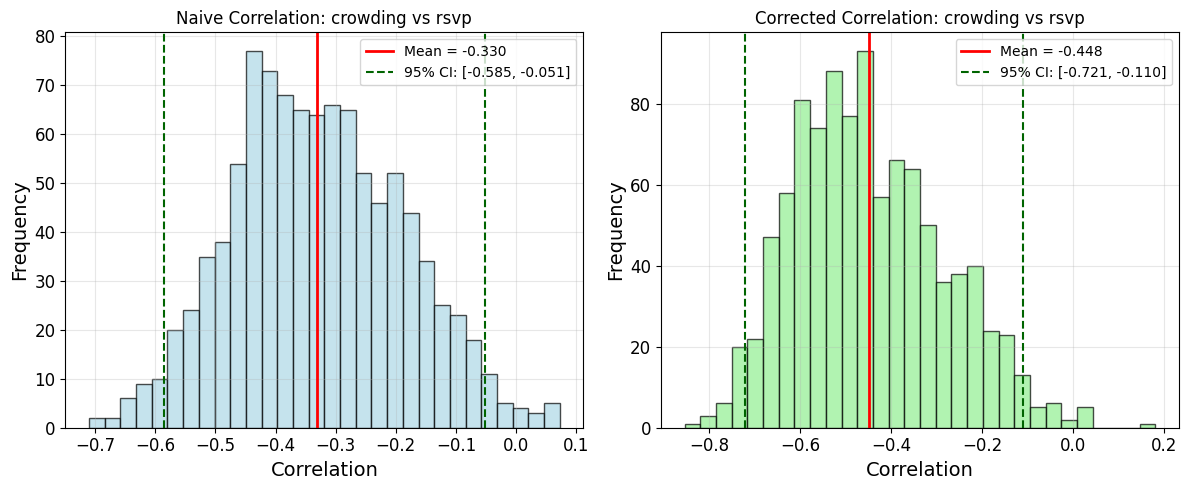


Analysis: crowding vs reading

1. Regular Bootstrap (Arithmetic Mean of Logs):
Mean correlation: -0.021
95% CI: [-0.263, 0.184]

2. Bootstrap with Spearman Correction:


/Users/annabruns/opt/anaconda3/envs/ds-vscode/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/annabruns/opt/anaconda3/envs/ds-vscode/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Mean correlation (corrected): 0.015
95% CI: [-0.354, 0.303]


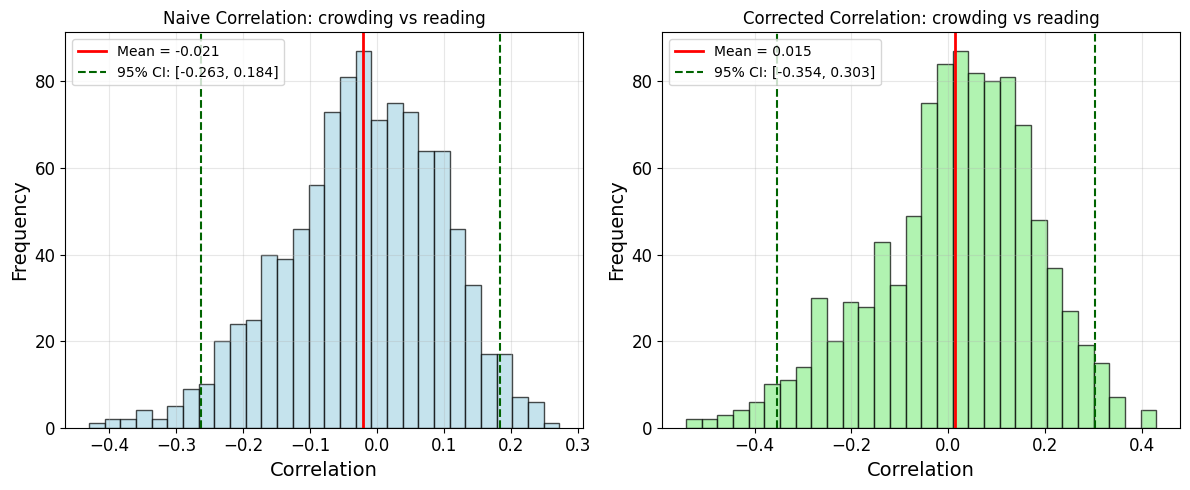


Analysis: acuity vs rsvp

1. Regular Bootstrap (Arithmetic Mean of Logs):
Mean correlation: nan
95% CI: [nan, nan]

2. Bootstrap with Spearman Correction:
Mean correlation (corrected): nan
95% CI: [nan, nan]

Analysis: acuity vs reading

1. Regular Bootstrap (Arithmetic Mean of Logs):
Mean correlation: nan
95% CI: [nan, nan]

2. Bootstrap with Spearman Correction:
Mean correlation (corrected): nan
95% CI: [nan, nan]

Analysis: rsvp vs reading

1. Regular Bootstrap (Arithmetic Mean of Logs):
Mean correlation: 0.473
95% CI: [0.243, 0.667]

2. Bootstrap with Spearman Correction:


/Users/annabruns/opt/anaconda3/envs/ds-vscode/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/annabruns/opt/anaconda3/envs/ds-vscode/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/annabruns/opt/anaconda3/envs/ds-vscode/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/annabruns/opt/anaconda3/envs/ds-vscode/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Mean correlation (corrected): 0.514
95% CI: [0.271, 0.715]


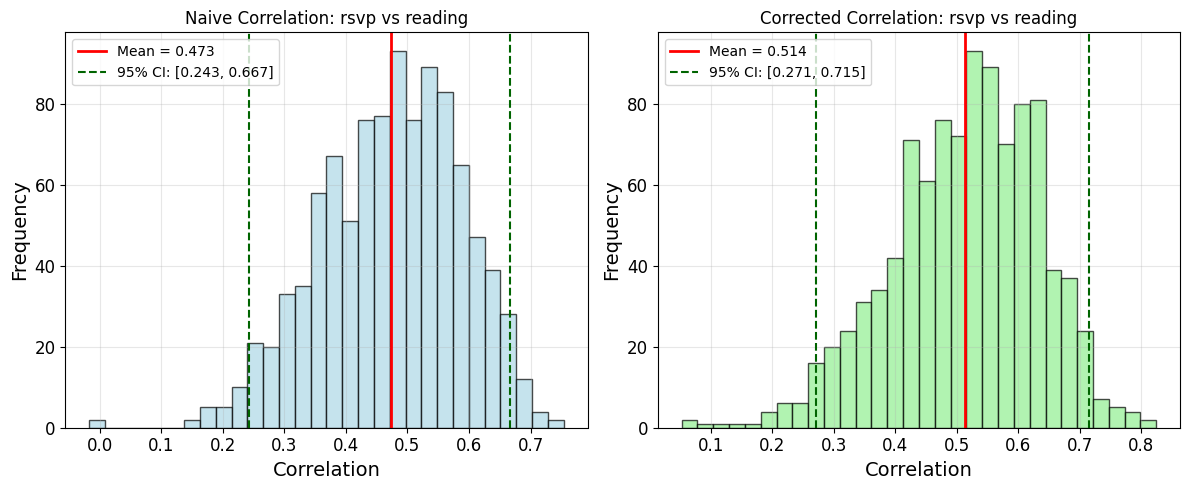

In [22]:
# Set random seed for reproducibility
#np.random.seed(123)

# Parameters
n_boot = 1000
sample_size = 30

results = run_all_analyses(df_for_boot, n_boot, sample_size)